In [3]:
!pip install PyTDC pandas numpy scikit-learn biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.3/151.3 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 3.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 91.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
from tdc.multi_pred import DTI
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Data

# Data Visualization
['davis', 'kiba', 'bindingdb_kd', 'bindingdb_ic50', 'bindingdb_ki', 'bindingdb_patent']

Downloading...
100%|██████████| 839M/839M [00:36<00:00, 23.2MiB/s]
Loading...
Done!
The scale is in original affinity scale, so we will take the minimum!
The original data has been updated!


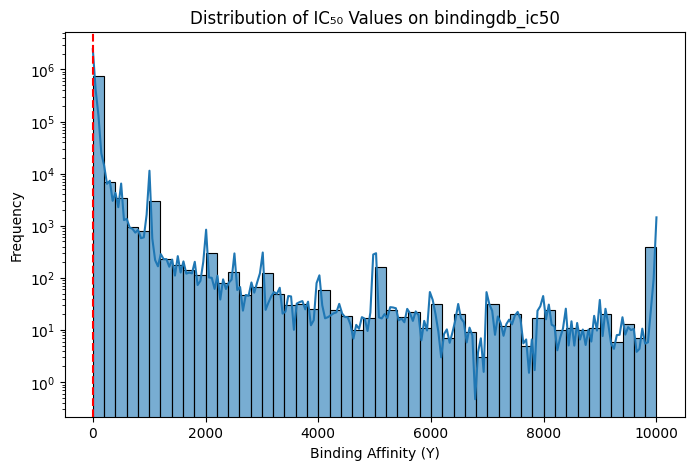

In [2]:
dti_bindingdb_ic50 = DTI(name='bindingdb_ic50')
dti_bindingdb_ic50.harmonize_affinities(mode='max_affinity')
data_bindingdb_ic50 = dti_bindingdb_ic50.get_data()

data_bindingdb_ic50['Y'] = data_bindingdb_ic50['Y'] / 1000

plt.figure(figsize=(8, 5))
sns.histplot(data_bindingdb_ic50['Y'], bins=50, kde=True, alpha=0.6)
plt.axvline(x=10, color='red', linestyle='--', label='Threshold (Y < 10)')
plt.yscale("log")
plt.xlabel("Binding Affinity (Y)")
plt.ylabel("Frequency")
plt.title("Distribution of IC₅₀ Values on bindingdb_ic50")
plt.show()

Downloading...
100%|██████████| 21.4M/21.4M [00:01<00:00, 21.0MiB/s]
Loading...
Done!
The scale is in original affinity scale, so we will take the minimum!
The original data has been updated!


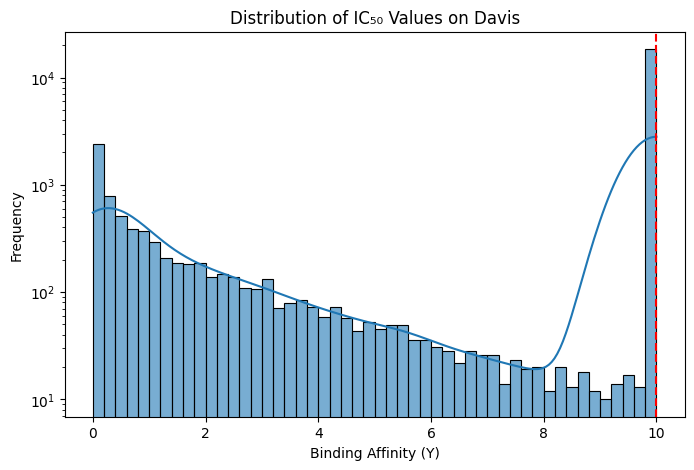

In [3]:
dti_davis = DTI(name='davis')
dti_davis.harmonize_affinities(mode='max_affinity')
data_davis = dti_davis.get_data()

data_davis['Y'] = data_davis['Y'] / 1000

plt.figure(figsize=(8, 5))
sns.histplot(data_davis['Y'], bins=50, kde=True, alpha=0.6)
plt.axvline(x=10, color='red', linestyle='--', label='Threshold (Y < 10)')
plt.yscale("log")
plt.xlabel("Binding Affinity (Y)")
plt.ylabel("Frequency")
plt.title("Distribution of IC₅₀ Values on Davis")
plt.show()

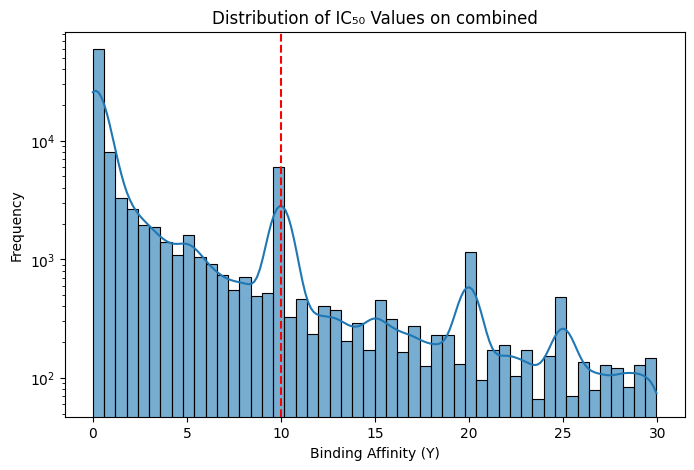

In [16]:
data = data_bindingdb_ic50[data_bindingdb_ic50['Y'] < 30]
data = data.sample(n=100000, random_state=42)

plt.figure(figsize=(8, 5))
sns.histplot(data['Y'], bins=50, kde=True, alpha=0.6)
plt.axvline(x=10, color='red', linestyle='--', label='Threshold (Y < 10)')
plt.yscale("log")
plt.xlabel("Binding Affinity (Y)")
plt.ylabel("Frequency")
plt.title("Distribution of IC₅₀ Values on combined")
plt.show()

# Data pre-processing

In [17]:
def smiles_to_fingerprint(smiles, radius=2, n_bits=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius, n_bits)

In [18]:
def fasta_to_features(fasta):
    try:
        analysis = ProteinAnalysis(fasta)
        aa_composition = analysis.get_amino_acids_percent()
        return list(aa_composition.values())
    except:
        return None

In [19]:
data.drop(columns=["Drug_ID", "Target_ID"], inplace=True)
data["Fingerprint"] = data["Drug"].apply(smiles_to_fingerprint)
data["AminoAcid_Features"] = data["Target"].apply(fasta_to_features)

In [22]:
X_smiles = np.stack(data["Fingerprint"].values)
X_fasta = np.stack(data["AminoAcid_Features"].values)
X_combined = np.hstack((X_smiles, X_fasta))
y = data["Y"].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42
)

In [24]:
print(data.isnull().sum())
print(data.isna().sum())

Drug                  0
Target                0
Y                     0
Fingerprint           0
AminoAcid_Features    0
dtype: int64
Drug                  0
Target                0
Y                     0
Fingerprint           0
AminoAcid_Features    0
dtype: int64


# Model Training

In [25]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [26]:
y_pred = model.predict(X_test)
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False)}")
print(f"R²: {r2_score(y_test, y_pred)}")

RMSE: 4.456343207026727
R²: 0.33987515878874586


## Save model

In [28]:
import joblib

joblib.dump(model, "model.pkl")

['model.pkl']